Объяснение параметра kernel_size=5
Размер ядра (kernel size) определяет длину "окна" данных, которые фильтр анализирует за один раз:

Экспертный выбор: Выбирается на основе понимания природы данных. Например, если есть краткосрочные тренды, такие как 5-дневные средние значения в ценах акций, ядро длиной 5 может подойти.
Перебор: Можно экспериментально выбирать размер ядра и проверять качество модели, начиная с небольших значений (3, 5, 7).
Что делать с фильтрами после обучения?
После обучения фильтры показывают, какие локальные паттерны были выделены:

Использовать фильтры для интерпретации:
Понять, какие закономерности (циклы, пики, тренды) модель выделяет.
Использовать активации фильтров для анализа данных:
Временной ряд можно анализировать через активации, чтобы выявлять те участки, которые максимально активируют определённый фильтр (например, всплески или тренды).
Как построить данные без этих фильтров?
Если вы хотите "убрать" влияние фильтров:

Удаление выделенных паттернов: Вычитаете результат свёртки фильтра из исходного временного ряда.
Реконструкция ряда: Используйте автоэнкодеры или фильтры нижних частот (low-pass filtering), чтобы удалить высокочастотные колебания, которые захватывают фильтры.
Пример:

python
Kopieren
Bearbeiten
filtered_data = price_norm - conv_output.mean(axis=-1)
Как идёт чистка сезонных данных?
Чистка сезонных данных включает:

Выделение сезонности: Используются методы декомпозиции временных рядов, такие как statsmodels.tsa.seasonal_decompose.
Удаление сезонности: После выделения сезонности она вычитается из исходного ряда:
python
Kopieren
Bearbeiten
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(price, model='additive', period=50)
seasonality_removed = price - decomposition.seasonal
Вывод: Фильтры CNN выделяют паттерны, аналогичные трендам и сезонности, а вычитаемые активации могут использоваться для очистки данных от таких компонентов.

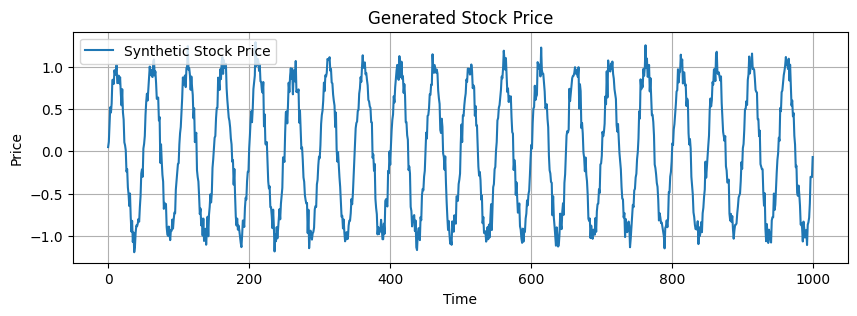

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input
from sklearn.preprocessing import MinMaxScaler

# 🔹 Генерация синтетического временного ряда цен акций
np.random.seed(42)
# t = np.linspace(0, 1, 200)  # Временной интервал
# price = 100 + 5 * np.sin(2 * np.pi * 4 * t) + np.random.normal(0, 1, size=len(t))  # Генерация цен

# # 🔹 Нормализация данных
# scaler = MinMaxScaler(feature_range=(0, 1))
# price_norm = scaler.fit_transform(price.reshape(-1, 1)).flatten()
# price_norm = price_norm.reshape(1, len(price_norm), 1)  # Формат для CNN: (batch, timesteps, channels)


# 🔹 Визуализация временного ряда
plt.figure(figsize=(10, 3))
plt.plot(range(time_steps), price_plot, label="Synthetic Stock Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Generated Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Отключение GPU
tf.config.set_visible_devices([], 'GPU')



Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step - loss: 0.5542
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2170
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0886
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1176
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1960
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


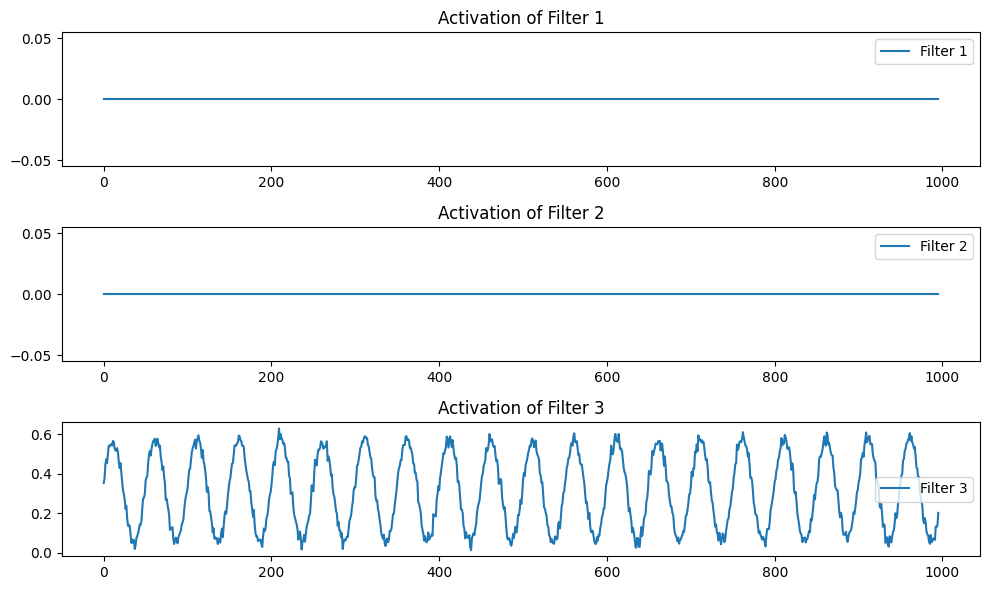

In [15]:


# 🔹 Создание модели с использованием явного Input
input_layer = Input(shape=(time_steps, 1))
conv_layer = Conv1D(filters=3, kernel_size=5, activation="relu")(input_layer)
flattened_layer = Flatten()(conv_layer)
output_layer = Dense(1, activation="linear")(flattened_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# 🔹 Компиляция и вызов модели
model.compile(optimizer="adam", loss="mse")
model.fit(price_norm, price_norm, epochs=5, verbose=1)  # Модель вызывается

# 🔹 Извлечение активаций первого слоя
conv_layer_model = Model(inputs=model.input, outputs=conv_layer)
conv_output = conv_layer_model.predict(price_norm)  # Получаем активации

# 🔹 Визуализация активаций фильтров
plt.figure(figsize=(10, 6))
for i in range(conv_output.shape[2]):  # Перебираем фильтры
    plt.subplot(conv_output.shape[2], 1, i + 1)
    plt.plot(conv_output[0, :, i], label=f"Filter {i + 1}")
    plt.title(f"Activation of Filter {i + 1}")
    plt.legend()
plt.tight_layout()
plt.show()